<h2>Multiple Rotations</h2>

The trivial way of implementing more than one rotation in parallel is to use a separate qubit for each rotation.

If we have $ t $ different rotations with angles $ \theta_1,\ldots,\theta_t $, then we can use $ t $ qubits.

Alternatively, we can use $ \log_2 (t) + 1 $ qubits (assuming that $t$ is a power of 2) that implement the following unitary matrix:

$$
    R(\theta_1,\ldots,\theta_t) = 
    \mymatrix{rr|rr|cc|rr}{
        \cos \theta_1 & -\sin \theta_1 & 0 & 0 & \cdots & \cdots & 0 & 0 \\ 
        \sin \theta_1 & \cos \theta_1 & 0 & 0 & \cdots & \cdots & 0 & 0 \\ \hline
        0 & 0 & \cos \theta_2 & -\sin \theta_2 & \cdots & \cdots  & 0 & 0  \\ 
        0 & 0 & \sin \theta_2 & \cos \theta_2 & \cdots & \cdots  & 0 & 0 \\ \hline
        \vdots & \vdots & \vdots & \vdots & \ddots & & \vdots & \vdots \\ 
        \vdots & \vdots & \vdots & \vdots & & \ddots & \vdots & \vdots \\ \hline
        0 & 0 & 0 & 0 & \cdots & \cdots & \cos \theta_t & -\sin \theta_t \\ 
        0 & 0 & 0 & 0 & \cdots & \cdots & \sin \theta_t & \cos \theta_t \\ 
    } .
$$

We can use this idea to solve the problem $\sf MOD_p$ (see <a href="B72_Rotation_Automata.ipynb" target="_blank">Rotation Automata</a>). 

We implement $ t $ rotation automata in this way.

At the beginning of the computation, we apply Hadamard operator in each qubit. Then, we apply the operator $ R(\theta_1,\ldots,\theta_t) $ for each symbol from the stream. Once the stream is finished, we apply Hadamard operator in each qubit again. 

If we observe only state 0 in each qubit, then we consider the stream having the length of a multiple of $\sf p$. Otherwise, we consider the stream having the length of not a multiple of $\sf p$.

<h3> Constructing $ R(\theta_1,\theta_2) $ </h3>

When $t=2$, $ \log_2 (2) + 1 = 2 $. So, both implementations use the same number of qubits.

But, it is a good starting point to construct the following unitary operator:

$$
    R(\theta_1,\theta_2) =
    \mymatrix{rrrr}{ 
        \cos \theta_1 & -\sin \theta_1 & 0 & 0 \\
        \sin \theta_1 & \cos \theta_1 & 0 & 0 \\
        0 & 0 & \cos \theta_2 & -\sin \theta_2 \\
        0 & 0 & \sin \theta_2 & \cos \theta_2 \\
    } .
$$

<div style="background-color:#f8f8f8;">
<b> Technical Remark:</b>

When two qubits are combined (tensored) in qiskit, say $  qreg[0] $ and $ qreg[1] $, they are ordered as $ qreg[1] \otimes qreg[0] $.

If there are $n$ qubits, say $ qreg[0],\ldots,qreg[n-1] $ to be combined, they are ordered in qiskit as 

$$ qreg[n-1] \otimes \cdots \otimes qreg[0] .  $$
</div>

We use a controlled rotation gate $ cu3 $ in qiskit. 

<b> Gate $u3$: </b>

The gate $ u3 $ is a generic one-qubit gate for rotation on Bloch sphere. It takes three parameters, and if we pass zeros as the second and third parameters, we implement our rotation gate $ ry $:

    u3(2*theta,0,0,qubit)
is equivalent to

    ry(2*theta,qubit)
Both make a rotation with angle $\theta$ in the real-valued qubit in counter-clockwise direction.

<b> Gate $cu3$: </b>

The two-qubit gate $ cu3 $ takes five parameters. We use it as follows:

    cu3(2*theta,0,0,control_qubit,target_qubit)
If the control qubit is in state $ \ket{1} $, then the rotation
    
    ry(2*theta,target_qubit)
is applied (to the target qubit).   

The base states of two qubits are ordered as $ \myarray{c}{00 \\ 01 \\ 10 \\ 11 } $ 
or equivalently grouped as $ \myarray{c}{ 0 \otimes \myvector{0 \\ 1} \\ \hline 1 \otimes \myvector{0 \\ 1} } $. 

We can apply a rotation to the first qubit controlled by the second qubit.

To construct $ R(\theta_1,\theta_2) $:
<ol>
    <li> When the second qubit is in state $ \ket{0} $, we can apply the rotation with angle $ \theta_1 $. </li>
    <li> When the second qubit is in state $ \ket{1} $, we can apply the rotation with angle $ \theta_2 $. </li>
</ol>

Now, we implement this by also printing the constructed unitary matrix.

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from math import pi

# the angles of rotations
theta1 = pi/4
theta2 = pi/6

# the circuit with two qubits
qreg = QuantumRegister(2) 
creg = ClassicalRegister(2) 
mycircuit = QuantumCircuit(qreg,creg)


# when the second qubit is in |0>, the first qubit is rotated by theta1
mycircuit.x(qreg[1])
mycircuit.cu3(2*theta1,0,0,qreg[1],qreg[0])
mycircuit.x(qreg[1])

# when the second qubit is in |1>, the first qubit is rotated by theta2
mycircuit.cu3(2*theta2,0,0,qreg[1],qreg[0])
              
# we read the unitary matrix
job = execute(mycircuit,Aer.get_backend('unitary_simulator'),optimization_level=0)
u=job.result().get_unitary(mycircuit,decimals=3)
# we print the unitary matrix in nice format
for i in range(len(u)):
    s=""
    for j in range(len(u)):
        val = str(u[i][j].real)
        while(len(val)<8): val  = " "+val
        s = s + val
    print(s)
    



0.7071067811865476-0.7071067811865476     0.0     0.0
0.70710678118654760.7071067811865476     0.0     0.0
     0.0     0.00.8660254037844387-0.49999999999999994
     0.0     0.00.499999999999999940.8660254037844387


<ipython-input-1-60fbee3dce11>:16: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  mycircuit.cu3(2*theta1,0,0,qreg[1],qreg[0])
<ipython-input-1-60fbee3dce11>:20: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  mycircuit.cu3(2*theta2,0,0,qreg[1],qreg[0])


<h3>Task 1</h3>

Verify that the printed matrix is $ R(\pi/4,\pi/6) $.

<h3>Solution</h3>

In [2]:
from math import pi, sin, cos

theta1 = pi/4
theta2 = pi/6

print(round(cos(theta1),3),-round(sin(theta1),3),0,0)
print(round(sin(theta1),3),-round(cos(theta1),3),0,0)
print(0,0,round(cos(theta2),3),-round(sin(theta2),3))
print(0,0,round(sin(theta2),3),-round(cos(theta2),3))

0.707 -0.707 0 0
0.707 -0.707 0 0
0 0 0.866 -0.5
0 0 0.5 -0.866


<h3> Constructing $ R(\theta_1,\theta_2,\theta_3,\theta_4) $ </h3>

We can use $ \log_2(4) + 1 = 3 $ qubits to construct $ R(\theta_1,\theta_2,\theta_3,\theta_4) $.

The base states of three qubits are ordered as $ \myarray{c}{000 \\ 001 \\ 010 \\ 011 \\ 100 \\ 101 \\ 110 \\ 111 } $ 
or equivalently grouped as $ 
    \myarray{c}{ 
    00 \otimes \myvector{0 \\ 1} \\ \hline 
    01 \otimes \myvector{0 \\ 1} \\ \hline 
    10 \otimes \myvector{0 \\ 1}  \\ \hline 
    11 \otimes \myvector{0 \\ 1} 
    } $. 

By using a rotation gate controlled by two qubits, we can easily implement our unitary operator.

But, if we have a rotation gate controlled by only one qubit, then we use additional tricks (and qubits) and controlled CNOT gate by two qubits (also called Toffoli gate):

    circuit.ccx(control-qubit1,control-qubit2,target-qubit)
<div style="background-color:#f9f9f9;">
In general, if $ t = 2^n $, then we can construct $ R(\theta_1,\ldots,\theta_t) $ by using no more than $ 2\log_2(t) $ qubits (instead of $t$ qubits). 
</div>

<h3> Pseudo construction </h3>
    
We start with a construction using three angles.

<h3> Task 2</h3>

Consider a quantum circuit with 3 qubits.

When the third qubit is in state $ \ket{1} $, apply the gate 

    cu3(2*theta1,0,0,qreg[2],qreg[0]) 

When the second qubit is in state $ \ket{1} $, apply the gate
    
    cu3(2*theta2,0,0,qreg[1],qreg[0])
    
When the third qubit is in state $ \ket{0} $, apply the gate

    cu3(2*theta3,0,0,qreg[2],qreg[0])

Guess the corresponding unitary matrix, which should be of the form:

$$
    \mymatrix{rr|rr|rr|rr}{
        \cos a_1 & -\sin a_1 & 0 & 0 & 0 & 0 & 0 & 0 \\
        \sin a_1 & \cos a_1 & 0 & 0 & 0 & 0 & 0 & 0 \\ \hline
        0 & 0 & \cos a_2 & -\sin a_2 & 0 & 0 & 0 & 0  \\
         0 & 0 & \sin a_2 & \cos a_2 & 0 & 0 & 0 & 0 \\ \hline
        0 & 0 & 0 & 0 & \cos a_3 & -\sin a_3 & 0 & 0  \\
         0 & 0 & 0 & 0 & \sin a_3 & \cos a_3 & 0 & 0  \\ \hline
        0 & 0 & 0 & 0 & 0 & 0 & \cos a_4 & -\sin a_4 \\
        0 & 0 & 0 & 0 & 0 & 0 & \sin a_4 & \cos a_4 \\ 
    }
$$

In other words, find $a_1$, $ a_2 $, $a_3$, and $a_4$ in terms of $ \theta_1 $, $\theta_2$, and $ \theta_3 $.

<h3>Solution</h3>

We use a table to easily trace the rotations applied to the first qubit:

$$
    \myarray{|c|c|c|c|l|}{
    \hline
      states & qreg[2] = \ket{1} &  qreg[1] = \ket{1} &  qreg[2] = \ket{0} & rotations \\ \hline
      00 & & & \theta_3 & a_1 =  \theta_3 \\ \hline
      01 & & \theta_2 & \theta_3 & a_2 =  \theta_2 + \theta_3 \\ \hline
      10 & \theta_1 & &  & a_3 =  \theta_1 \\ \hline
      11 & \theta_1 & \theta_2 &  & a_4 =  \theta_1 + \theta_2 \\ \hline
    }
$$

<h3>Task 3</h3>

Implement Task 2 by picking three angles, and verify the constructed matrix.

<h3>Solution</h3>

In [3]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from math import pi, sin, cos

# the angle of rotation
theta1 = pi/23
theta2 = 2*pi/23
theta3 = 4*pi/23


precision = 3

print("a1 = theta3 => sin(a1) = ",round(sin(theta3),precision))
print("a2 = theta2+theta3 => sin(a2) = ",round(sin(theta2+theta3),precision))
print("a3 = theta1 => sin(a3) = ",round(sin(theta1),precision))
print("a4 = theta1+theta2 => sin(a4) = ",round(sin(theta1+theta2),precision))
print()

qreg = QuantumRegister(3) 
creg = ClassicalRegister(3) 
circuit = QuantumCircuit(qreg,creg)

# controlled rotation when the third qubit is |1>
circuit.cu3(2*theta1,0,0,qreg[2],qreg[0])

# controlled rotation when the second qubit is |1>
circuit.cu3(2*theta2,0,0,qreg[1],qreg[0])

# controlled rotation when the third qubit is |0>
circuit.x(qreg[2])
circuit.cu3(2*theta3,0,0,qreg[2],qreg[0])
circuit.x(qreg[2])

# read the corresponding unitary matrix
job = execute(circuit,Aer.get_backend('unitary_simulator'),optimization_level=0)
unitary_matrix=job.result().get_unitary(circuit,decimals=precision)
for i in range(len(unitary_matrix)):
    s=""
    for j in range(len(unitary_matrix)):
        val = str(unitary_matrix[i][j].real)
        while(len(val)<precision+4): val  = " "+val
        s = s + val
    print(s)

a1 = theta3 => sin(a1) =  0.52
a2 = theta2+theta3 => sin(a2) =  0.731
a3 = theta1 => sin(a3) =  0.136
a4 = theta1+theta2 => sin(a4) =  0.398

0.8544194045464886-0.5195839500354336    0.0    0.0    0.0    0.0    0.0    0.0
0.51958395003543360.8544194045464886    0.0    0.0    0.0    0.0    0.0    0.0
    0.0    0.00.6825531432186542-0.7308359642781241    0.0    0.0    0.0    0.0
    0.0    0.00.73083596427812410.6825531432186542    0.0    0.0    0.0    0.0
    0.0    0.0    0.0    0.00.9906859460363308-0.1361666490962466    0.0    0.0
    0.0    0.0    0.0    0.00.13616664909624660.9906859460363308    0.0    0.0
    0.0    0.0    0.0    0.0    0.0    0.00.917211301505453-0.3984010898462415
    0.0    0.0    0.0    0.0    0.0    0.00.39840108984624150.917211301505453


<ipython-input-3-346895a01e7b>:23: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  circuit.cu3(2*theta1,0,0,qreg[2],qreg[0])
<ipython-input-3-346895a01e7b>:26: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  circuit.cu3(2*theta2,0,0,qreg[1],qreg[0])
<ipython-input-3-346895a01e7b>:30: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  circuit.cu3(2*theta3,0,0,qreg[2],qreg[0])


<h3>Task 4</h3>

Create a circuit for solving problem $ \sf MOD_{31} $ by using the implementation in Task 3.

Pick $ \theta_1 $, $ \theta_2 $, and $ \theta_3 $ randomly.

At the beginning of the stream and after reading the stream, apply Hadamard operators to each qubit.

Execute your quantum program on the streams of lengths from 1 to 31.

<h3>Solution</h3>

In [4]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from math import pi, sin, cos
from random import randrange

# the angle of rotation
k1 = randrange(1,31)
theta1 = k1*2*pi/31
k2 = randrange(1,31)
theta2 = k2*2*pi/31
k3 = randrange(1,31)
theta3 = k3*2*pi/31

max_percentange = 0
    
# for each stream of length from 1 to 31
for i in range(1,32):    
    # initialize the circuit
    qreg = QuantumRegister(3) 
    creg = ClassicalRegister(3) 
    circuit = QuantumCircuit(qreg,creg)
    
    # Hadamard operators before reading the stream
    for m in range(3):
        circuit.h(qreg[m])   
        
    # read the stream of length i
    print("stream of length",i,"is being read")
    for j in range(i):    
        # controlled rotation when the third qubit is |1>
        circuit.cu3(2*theta1,0,0,qreg[2],qreg[0])

        # controlled rotation when the second qubit is |1>
        circuit.cu3(2*theta2,0,0,qreg[1],qreg[0])

        # controlled rotation when the third qubit is |0>
        circuit.x(qreg[2])
        circuit.cu3(2*theta3,0,0,qreg[2],qreg[0])
        circuit.x(qreg[2])
        
    # Hadamard operators after reading the stream
    for m in range(3):
        circuit.h(qreg[m])  
    # we measure after reading the whole stream
    circuit.measure(qreg,creg)
    # execute the circuit N times
    N = 1000
    job = execute(circuit,Aer.get_backend('qasm_simulator'),shots=N)
    counts = job.result().get_counts(circuit)
    print(counts)
    if '000' in counts.keys():
        c = counts['000']
    else:
        c = 0
    print('000 is observed',c,'times out of',N)
    percentange = round(c/N*100,1)
    if max_percentange < percentange and i != 31: max_percentange = percentange
    print("the ration of 000 is ",percentange,"%")
    print()  
print("maximum percentage of observing unwanted '000' is",max_percentange)

stream of length 1 is being read
{'000': 3, '001': 59, '010': 6, '100': 837, '101': 23, '110': 2, '111': 70}
000 is observed 3 times out of 1000
the ration of 000 is  0.3 %

stream of length 2 is being read
{'000': 464, '001': 41, '010': 10, '011': 245, '100': 16, '101': 147, '110': 66, '111': 11}
000 is observed 464 times out of 1000
the ration of 000 is  46.4 %

stream of length 3 is being read
{'000': 34, '001': 148, '010': 232, '011': 68, '100': 144, '101': 50, '110': 72, '111': 252}
000 is observed 34 times out of 1000
the ration of 000 is  3.4 %

stream of length 4 is being read
{'000': 24, '001': 8, '010': 60, '011': 177, '100': 23, '101': 64, '110': 415, '111': 229}
000 is observed 24 times out of 1000
the ration of 000 is  2.4 %

stream of length 5 is being read
{'000': 1, '010': 461, '011': 420, '101': 1, '110': 48, '111': 69}
000 is observed 1 times out of 1000
the ration of 000 is  0.1 %

stream of length 6 is being read
{'010': 1, '100': 34, '101': 30, '110': 350, '111': 5

<ipython-input-4-4153ed0e40de>:30: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  circuit.cu3(2*theta1,0,0,qreg[2],qreg[0])
<ipython-input-4-4153ed0e40de>:33: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  circuit.cu3(2*theta2,0,0,qreg[1],qreg[0])
<ipython-input-4-4153ed0e40de>:37: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  circuit.cu3(2*theta3,0,0,qreg[2],qreg[0])


{'000': 93, '001': 2, '011': 1, '100': 12, '101': 860, '110': 32}
000 is observed 93 times out of 1000
the ration of 000 is  9.3 %

stream of length 21 is being read
{'001': 671, '010': 3, '100': 319, '101': 1, '111': 6}
000 is observed 0 times out of 1000
the ration of 000 is  0.0 %

stream of length 22 is being read
{'000': 463, '001': 12, '010': 2, '011': 85, '100': 13, '101': 362, '110': 62, '111': 1}
000 is observed 463 times out of 1000
the ration of 000 is  46.3 %

stream of length 23 is being read
{'000': 13, '001': 100, '010': 90, '011': 9, '100': 390, '101': 54, '110': 39, '111': 305}
000 is observed 13 times out of 1000
the ration of 000 is  1.3 %

stream of length 24 is being read
{'000': 194, '001': 53, '010': 152, '011': 570, '100': 2, '101': 12, '110': 12, '111': 5}
000 is observed 194 times out of 1000
the ration of 000 is  19.4 %

stream of length 25 is being read
{'010': 2, '011': 1, '100': 33, '101': 24, '110': 334, '111': 606}
000 is observed 0 times out of 1000
the

<h3>Task 5 (optional)</h3>

Based on Task 4, design your own solution for problem $ \sf MOD_{91} $ by using four qubits.

Remark that up to 8 different rotations can be implemented by using four qubits.

In [ ]:
#
# your solution is here
#


<h3> Main construction </h3>

To implement an operator controlled by two qubits, we use an auxiliary qubit.

Depending on the desired values of two qubits, the auxiliary qubit is flipped to $ \ket{1} $ and then the operation is implemented controlled by the auxiliary qubit.

Here we describe the case when the control qubits are in state $ \ket{01} $. 

We also draw the circuit. 

In [5]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from math import pi

# initialize the circuit
qreg = QuantumRegister(4)  
circuit = QuantumCircuit(qreg)

# we use the fourth qubit as the auxiliary

# apply a rotation to the first qubit when the third and second qubits are in states |0> and |1>
# change the state of the third qubit to |1>
circuit.x(qreg[2])
# if both the third and second qubits are in states |1>, the state of auxiliary qubit is changed to |1> 
circuit.ccx(qreg[2],qreg[1],qreg[3])
# the rotation is applied to the first qubit if the state of auxiliary qubit is |1>
circuit.cu3(2*pi/6,0,0,qreg[3],qreg[0])
# reverse the effects
circuit.ccx(qreg[2],qreg[1],qreg[3])
circuit.x(qreg[2])

circuit.draw()

<ipython-input-5-2897c18c457a>:16: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  circuit.cu3(2*pi/6,0,0,qreg[3],qreg[0])


┌─────────────┐          
q161_0: ──────────┤ U3(π/3,0,0) ├──────────
                  └──────┬──────┘          
q161_1: ───────■─────────┼─────────■───────
        ┌───┐  │         │         │  ┌───┐
q161_2: ┤ X ├──■─────────┼─────────■──┤ X ├
        └───┘┌─┴─┐       │       ┌─┴─┐└───┘
q161_3: ─────┤ X ├───────■───────┤ X ├─────
             └───┘               └───┘

Based on this idea, different rotation operators are applied to the first qubit when the third and second qubits are in $ \ket{00} $, $ \ket{01} $, $ \ket{10} $, and $ \ket{11} $. 

We present how to construct $ R(\pi/10,2\pi/10,3\pi/10,4\pi/10) $. 

In [6]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from math import pi,sin

# the angles of rotations
theta1 = pi/10
theta2 = 2*pi/10
theta3 = 3*pi/10
theta4 = 4*pi/10

# for verification, print sin(theta)'s
print("sin(theta1) = ",round(sin(theta1),3))
print("sin(theta2) = ",round(sin(theta2),3))
print("sin(theta3) = ",round(sin(theta3),3))
print("sin(theta4) = ",round(sin(theta4),3))
print()

qreg =  QuantumRegister(4) 
circuit = QuantumCircuit(qreg)

# the third qubit is in |0>
# the second qubit is in |0>
circuit.x(qreg[2])
circuit.x(qreg[1])
circuit.ccx(qreg[2],qreg[1],qreg[3])
circuit.cu3(2*theta1,0,0,qreg[3],qreg[0])
# reverse the effects
circuit.ccx(qreg[2],qreg[1],qreg[3])
circuit.x(qreg[1])
circuit.x(qreg[2])


# the third qubit is in |0>
# the second qubit is in |1>
circuit.x(qreg[2])
circuit.ccx(qreg[2],qreg[1],qreg[3])
circuit.cu3(2*theta2,0,0,qreg[3],qreg[0])
# reverse the effects
circuit.ccx(qreg[2],qreg[1],qreg[3])
circuit.x(qreg[2])

# the third qubit is in |1>
# the second qubit is in |0>
circuit.x(qreg[1])
circuit.ccx(qreg[2],qreg[1],qreg[3])
circuit.cu3(2*theta3,0,0,qreg[3],qreg[0])
# reverse the effects
circuit.ccx(qreg[2],qreg[1],qreg[3])
circuit.x(qreg[1])

# the third qubit is in |1>
# the second qubit is in |1>
circuit.ccx(qreg[2],qreg[1],qreg[3])
circuit.cu3(2*theta4,0,0,qreg[3],qreg[0])
# reverse the effects
circuit.ccx(qreg[2],qreg[1],qreg[3])

# read the corresponding unitary matrix
job = execute(circuit,Aer.get_backend('unitary_simulator'),optimization_level=0)
unitary_matrix=job.result().get_unitary(circuit,decimals=3)
for i in range(len(unitary_matrix)):
    s=""
    for j in range(len(unitary_matrix)):
        val = str(unitary_matrix[i][j].real)
        while(len(val)<7): val  = " "+val
        s = s + val
    print(s)

sin(theta1) =  0.309
sin(theta2) =  0.588
sin(theta3) =  0.809
sin(theta4) =  0.951

0.9510565162951535-0.3090169943749474    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
0.30901699437494740.9510565162951535    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
    0.0    0.00.8090169943749475-0.5877852522924731    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
    0.0    0.00.58778525229247310.8090169943749475    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
    0.0    0.0    0.0    0.00.5877852522924731-0.8090169943749475    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
    0.0    0.0    0.0    0.00.80901699437494750.5877852522924731    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
    0.0    0.0    0.0    0.0    0.0    0.00.30901699437494745-0.9510565162951535    0.0    0.0    0.0 

<ipython-input-6-a4273923a880>:25: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  circuit.cu3(2*theta1,0,0,qreg[3],qreg[0])
<ipython-input-6-a4273923a880>:36: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  circuit.cu3(2*theta2,0,0,qreg[3],qreg[0])
<ipython-input-6-a4273923a880>:45: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  circuit.cu3(2*theta3,0,0,qreg[3],qreg[0])
<ipython-input-6-a4273923a880>:53: DeprecationWarning: The QuantumCirc

<b>Remarks:</b> 

The constructed matrix is bigger than our main matrix because of the auxiliary qubit.

Our main matrix appears at the top-left quarter of the constructed matrix.

The rest of the constructed matrix does not affect our computation unless the auxiliary qubit is set to state $ \ket{1} $ (except the auxiliary operations).

<h3>Task 6 (optional)</h3>

Assume that $\theta_1=\frac{\pi}{11}$, $\theta_2=2\frac{\pi}{11}$, $\theta_3=4\frac{\pi}{11}$, and $\theta_4=8\frac{\pi}{11}$ are the given angles in the above construction.

Calculate (by hand or in your mind) the angles of the rotations in the bottom-left quarter of the constructed matrix by following the construction steps.

<h3>Task 7</h3>

Create a circuit for solving problem $ \sf MOD_{61} $ by using the above implementation.

Pick $ \theta_1 $, $ \theta_2 $, $ \theta_3 $, and $ \theta_4 $ randomly.

At the beginning of the stream and after reading the stream, apply Hadamard operators to each qubit.

Execute your quantum program on the streams of lengths 1, 11, 21, 31, 41, 51, and 61.

<h3>Solution</h3>

In [7]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from math import pi,sin
from random import randrange

# the angle of rotation
k1 = randrange(1,61)
theta1 = k1*2*pi/61
k2 = randrange(1,61)
theta2 = k2*2*pi/61
k3 = randrange(1,61)
theta3 = k3*2*pi/61
k4 = randrange(1,61)
theta4 = k4*2*pi/61

max_percentange = 0

# for each stream of length of 1, 11, 21, 31, 41, 51, and 61
for i in [1,11,21,31,41,51,61]: 
#for i in range(1,62): 
    # initialize the circuit
    qreg =  QuantumRegister(4) 
    creg = ClassicalRegister(4)
    circuit = QuantumCircuit(qreg,creg)

    # Hadamard operators before reading the stream
    for m in range(3):
        circuit.h(qreg[m])   
        
    # read the stream of length i
    print("stream of length",i,"is being read")
    for j in range(i):         
        # the third qubit is in |0>
        # the second qubit is in |0>
        circuit.x(qreg[2])
        circuit.x(qreg[1])
        circuit.ccx(qreg[2],qreg[1],qreg[3])
        circuit.cu3(2*theta1,0,0,qreg[3],qreg[0])
        # reverse the effects
        circuit.ccx(qreg[2],qreg[1],qreg[3])
        circuit.x(qreg[1])
        circuit.x(qreg[2])


        # the third qubit is in |0>
        # the second qubit is in |1>
        circuit.x(qreg[2])
        circuit.ccx(qreg[2],qreg[1],qreg[3])
        circuit.cu3(2*theta2,0,0,qreg[3],qreg[0])
        # reverse the effects
        circuit.ccx(qreg[2],qreg[1],qreg[3])
        circuit.x(qreg[2])

        # the third qubit is in |1>
        # the second qubit is in |0>
        circuit.x(qreg[1])
        circuit.ccx(qreg[2],qreg[1],qreg[3])
        circuit.cu3(2*theta3,0,0,qreg[3],qreg[0])
        # reverse the effects
        circuit.ccx(qreg[2],qreg[1],qreg[3])
        circuit.x(qreg[1])

        # the third qubit is in |1>
        # the second qubit is in |1>
        circuit.ccx(qreg[2],qreg[1],qreg[3])
        circuit.cu3(2*theta4,0,0,qreg[3],qreg[0])
        # reverse the effects
        circuit.ccx(qreg[2],qreg[1],qreg[3])
        
    # Hadamard operators after reading the stream
    for m in range(3):
        circuit.h(qreg[m])  
    # we measure after reading the whole stream
    circuit.measure(qreg,creg)
    # execute the circuit N times
    N = 1000
    job = execute(circuit,Aer.get_backend('qasm_simulator'),shots=N)
    counts = job.result().get_counts(circuit)
    print(counts)
    if '0000' in counts.keys():
        c = counts['0000']
    else:
        c = 0
    print('0000 is observed',c,'times out of',N)
    percentange = round(c/N*100,1)
    if max_percentange < percentange and i != 61: max_percentange = percentange
    print("the ration of 0000 is ",percentange,"%")
    print()  
print("maximum percentage of observing unwanted '0000' is",max_percentange)

stream of length 1 is being read
{'0000': 297, '0001': 76, '0010': 64, '0011': 3, '0100': 31, '0101': 9, '0110': 129, '0111': 391}
0000 is observed 297 times out of 1000
the ration of 0000 is  29.7 %

stream of length 11 is being read
{'0000': 103, '0001': 76, '0010': 216, '0011': 511, '0100': 4, '0101': 28, '0110': 14, '0111': 48}
0000 is observed 103 times out of 1000
the ration of 0000 is  10.3 %

stream of length 21 is being read
{'0000': 28, '0001': 226, '0010': 491, '0011': 6, '0100': 35, '0101': 141, '0110': 58, '0111': 15}
0000 is observed 28 times out of 1000
the ration of 0000 is  2.8 %

stream of length 31 is being read
{'0000': 172, '0001': 19, '0010': 14, '0011': 4, '0100': 1, '0101': 9, '0110': 40, '0111': 741}
0000 is observed 172 times out of 1000
the ration of 0000 is  17.2 %

stream of length 41 is being read
{'0001': 16, '0010': 12, '0011': 29, '0100': 308, '0101': 451, '0110': 91, '0111': 93}
0000 is observed 0 times out of 1000
the ration of 0000 is  0.0 %

stream 

<ipython-input-7-4f514113d619>:37: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  circuit.cu3(2*theta1,0,0,qreg[3],qreg[0])
<ipython-input-7-4f514113d619>:48: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  circuit.cu3(2*theta2,0,0,qreg[3],qreg[0])
<ipython-input-7-4f514113d619>:57: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  circuit.cu3(2*theta3,0,0,qreg[3],qreg[0])
<ipython-input-7-4f514113d619>:65: DeprecationWarning: The QuantumCirc

{'0000': 17, '0001': 130, '0010': 362, '0011': 104, '0100': 46, '0101': 228, '0110': 88, '0111': 25}
0000 is observed 17 times out of 1000
the ration of 0000 is  1.7 %

stream of length 61 is being read
{'0000': 1000}
0000 is observed 1000 times out of 1000
the ration of 0000 is  100.0 %

maximum percentage of observing unwanted '0000' is 29.7


<h3>Task 8</h3>

How many qubits we use to implement the main construction having 16 rotations in parallel?

Please specify the number of control qubits and auxiliary qubits.

<h3>Solution</h3>

For 16 rotations, we use 4 control qubits and 1 target qubit.

For each pair of control qubits, we use 1 auxiliray qubit. 

For 4 control qubits, we use two auxiliary qubits. 

Then, we use one more auxiliary qubit controlled by these two auxiliary qubits.

So, we need 4 control + 1 target + 3 auxiliary = 8 total qubits.

<h3>Bonus (saving some qubits)</h3>

We can use additional trick to save some qubits in our implementation. The idea relies on the following fact: if you apply a rotation between two NOT gates, the rotation will happen in the opposite direction.

We can use this idea to implement a rotation by $\theta$ in the following way:
<ul>
    <li>Rotate in the qubit by $\frac{\theta}{2}$;</li>
    <li>Apply NOT to the qubit;</li>
    <li>Rotate in the qubit by $-\frac{\theta}{2}$;</li>
    <li>Apply NOT to the qubit.</li>
</ul>

As a result we will rotate in the qubit by $\theta$. We can control NOT and rotation operations and perform a rotation only when all control qubits are in state 1, relying on the following simple facts:
<ul>
    <li>Two NOT gates result into identity operation;</li>
    <li>Rotations by $\frac{\theta}{2}$ and $-\frac{\theta}{2}$  result into identity operation.</li>
</ul>

Below you can see the code that shows how can we use the discussed ideas to control rotations on one qubit by three qubits. If the state of at least one of the control qubits is 0, then the identity will be applied to the controlled qubit.

<ipython-input-8-1b13e18c8b70>:13: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  mycircuit11.cu3(angle/2,0,0,q3,q4)
<ipython-input-8-1b13e18c8b70>:15: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  mycircuit11.cu3(-angle/2,0,0,q3,q4)


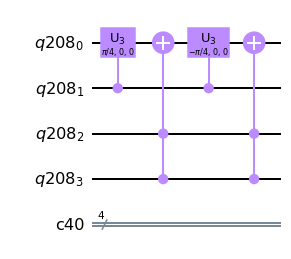

In [8]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from math import pi

qreg11 =  QuantumRegister(4)
creg11 = ClassicalRegister(4)

theta = pi/4

# define our quantum circuit
mycircuit11 = QuantumCircuit(qreg11,creg11)

def ccc_ry(angle,q1,q2,q3,q4):
    mycircuit11.cu3(angle/2,0,0,q3,q4)
    mycircuit11.ccx(q1,q2,q4)
    mycircuit11.cu3(-angle/2,0,0,q3,q4)
    mycircuit11.ccx(q1,q2,q4)
    
ccc_ry(2*theta,qreg11[3],qreg11[2],qreg11[1],qreg11[0])

mycircuit11.draw(output='mpl')

The code below demonstrates the implementation of 8 rotations with total 4 qubits, one of which is controlled by others.

In [9]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from math import pi

qreg12 =  QuantumRegister(4)
creg12 = ClassicalRegister(4)

theta1 = pi/16
theta2 = 2*pi/16
theta3 = 3*pi/16
theta4 = 4*pi/16
theta5 = 5*pi/16
theta6 = 6*pi/16
theta7 = 7*pi/16
theta8 = 8*pi/16

# define our quantum circuit
mycircuit12 = QuantumCircuit(qreg12,creg12)

def ccc_ry(angle,q1,q2,q3,q4):
    mycircuit12.cu3(angle/2,0,0,q3,q4)
    mycircuit12.ccx(q1,q2,q4)
    mycircuit12.cu3(-angle/2,0,0,q3,q4)
    mycircuit12.ccx(q1,q2,q4)
    
mycircuit12.x(qreg12[3])
mycircuit12.x(qreg12[2])
mycircuit12.x(qreg12[1])
ccc_ry(2*theta1,qreg12[3],qreg12[2],qreg12[1],qreg12[0])
mycircuit12.x(qreg12[1])
mycircuit12.x(qreg12[2])
mycircuit12.x(qreg12[3])

mycircuit12.x(qreg12[3])
mycircuit12.x(qreg12[2])
#mycircuit12.x(qreg12[1])
ccc_ry(2*theta2,qreg12[3],qreg12[2],qreg12[1],qreg12[0])
#mycircuit12.x(qreg12[1])
mycircuit12.x(qreg12[2])
mycircuit12.x(qreg12[3])

mycircuit12.x(qreg12[3])
#mycircuit12.x(qreg12[2])
mycircuit12.x(qreg12[1])
ccc_ry(2*theta3,qreg12[3],qreg12[2],qreg12[1],qreg12[0])
mycircuit12.x(qreg12[1])
#mycircuit12.x(qreg12[2])
mycircuit12.x(qreg12[3])

mycircuit12.x(qreg12[3])
#mycircuit12.x(qreg12[2])
#mycircuit12.x(qreg12[1])
ccc_ry(2*theta4,qreg12[3],qreg12[2],qreg12[1],qreg12[0])
#mycircuit12.x(qreg12[1])
#mycircuit12.x(qreg12[2])
mycircuit12.x(qreg12[3])

#mycircuit12.x(qreg12[3])
mycircuit12.x(qreg12[2])
mycircuit12.x(qreg12[1])
ccc_ry(2*theta5,qreg12[3],qreg12[2],qreg12[1],qreg12[0])
mycircuit12.x(qreg12[1])
mycircuit12.x(qreg12[2])
#mycircuit12.x(qreg12[3])

#mycircuit12.x(qreg12[3])
mycircuit12.x(qreg12[2])
#mycircuit12.x(qreg12[1])
ccc_ry(2*theta6,qreg12[3],qreg12[2],qreg12[1],qreg12[0])
#mycircuit12.x(qreg12[1])
mycircuit12.x(qreg12[2])
#mycircuit12.x(qreg12[3])

#mycircuit12.x(qreg12[3])
#mycircuit12.x(qreg12[2])
mycircuit12.x(qreg12[1])
ccc_ry(2*theta7,qreg12[3],qreg12[2],qreg12[1],qreg12[0])
mycircuit12.x(qreg12[1])
#mycircuit12.x(qreg12[2])
#mycircuit12.x(qreg12[3])

#mycircuit12.x(qreg12[3])
#mycircuit12.x(qreg12[2])
#mycircuit12.x(qreg12[1])
ccc_ry(2*theta8,qreg12[3],qreg12[2],qreg12[1],qreg12[0])
#mycircuit12.x(qreg12[1])
#mycircuit12.x(qreg12[2])
#mycircuit12.x(qreg12[3])

job = execute(mycircuit12,Aer.get_backend('unitary_simulator'),optimization_level=0)
u=job.result().get_unitary(mycircuit12,decimals=3)
for i in range(len(u)):
    s=""
    for j in range(len(u)):
        val = str(u[i][j].real)
        while(len(val)<7): val  = " "+val
        s = s + val
    print(s)

0.9807852804032304-0.1950903220161282    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
0.19509032201612820.9807852804032304    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
    0.0    0.00.9238795325112867-0.38268343236508984    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
    0.0    0.00.382683432365089840.9238795325112867    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
    0.0    0.0    0.0    0.00.8314696123025452-0.5555702330196022    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
    0.0    0.0    0.0    0.00.55557023301960220.8314696123025452    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
    0.0    0.0    0.0    0.0    0.0    0.00.7071067811865476-0.7071067811865476    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
    0.0    0.0    0.0    0.0    0.0    0.00.70710

<ipython-input-9-c6f3a984791e>:20: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  mycircuit12.cu3(angle/2,0,0,q3,q4)
<ipython-input-9-c6f3a984791e>:22: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  mycircuit12.cu3(-angle/2,0,0,q3,q4)


<h3>Task 9</h3>

By using the discussed ideas, how many qubits can we have to implement 16 rotations in parallel?

Please specify the number of control qubits and auxiliary qubits.

<h3>Solution</h3>

For 16 rotations, we use 4 control qubits and 1 target qubit.

We can use 2 control qubits to control the NOT operation (CC-NOT gate). 

The remaining 2 control qubits can control the auxiliary qubit, that is used as a controller for rotations. 

Then, the auxiliary qubit can be used to control the rotations on the targed qubit.

So, we need 4 control + 1 target + 1 auxiliary = 6 total qubits.